In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import numpy as np
import pandas as pd
import xarray as xr
from eofs.xarray import Eof
import esem

import warnings
warnings.filterwarnings('ignore')

2024-01-28 22:11:46.717426: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-28 22:11:46.717458: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Utilities for normalizing the emissions data
min_co2 = 0.
max_co2 = 2400
def normalize_co2(data):
    return data / max_co2

def un_normalize_co2(data):
    return data * max_co2

min_ch4 = 0.
max_ch4 = 0.6
def normalize_ch4(data):
    return data / max_ch4

def un_normalize_ch4(data):
    return data * max_ch4

data_path = "../"
# data_path = "F:\\Local Data\\ClimateBench\\"

In [3]:
# Get one combined historical + ssp585 timeseries for now
X = xr.open_mfdataset([data_path + 'inputs_historical.nc', data_path + 'inputs_ssp585.nc']).compute()
# Take the 2nd ensemble member for the historical (the first one has some missing DTR values for some reason...) and the 1st (only) one for SSP585
Y = xr.concat([xr.open_dataset(data_path + 'outputs_historical.nc').sel(member=2), xr.open_dataset(data_path + 'outputs_ssp585.nc').sel(member=1)], dim='time').compute()

# Convert the precip values to mm/day
Y["pr"] *= 86400
Y["pr90"] *= 86400

In [4]:
# Get the test data (NOT visible to contestants)

test_Y = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
test_X = xr.open_dataset(data_path + 'inputs_ssp245.nc').compute()


# Input dimensionality reduction

For this baseline example I've decided to only take the leading few EOFs of the aerosol emissions data using the `eofs` package.

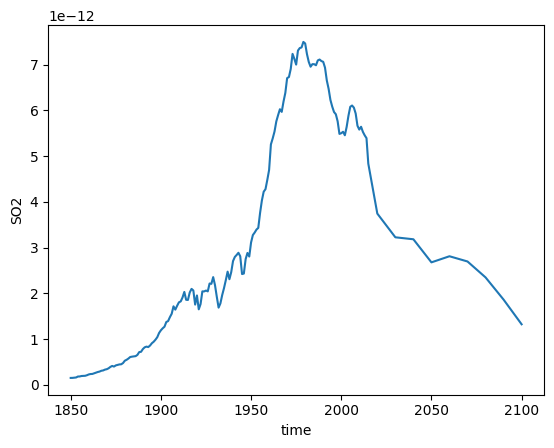

In [5]:
X['SO2'].mean(['latitude', 'longitude']).plot()

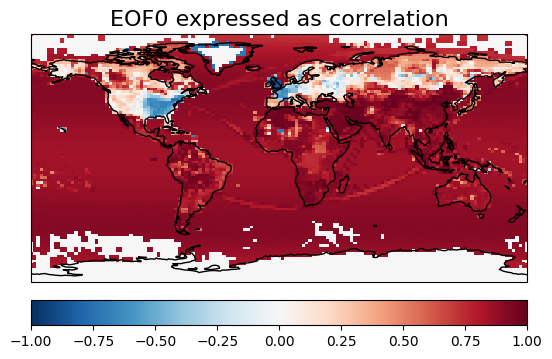

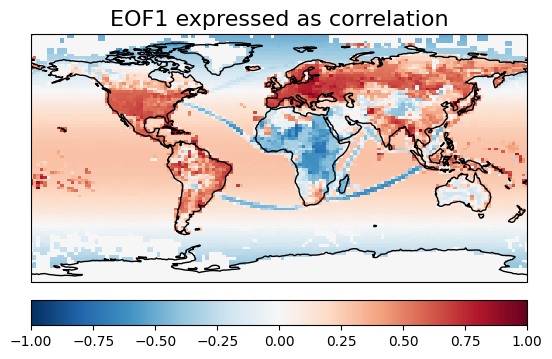

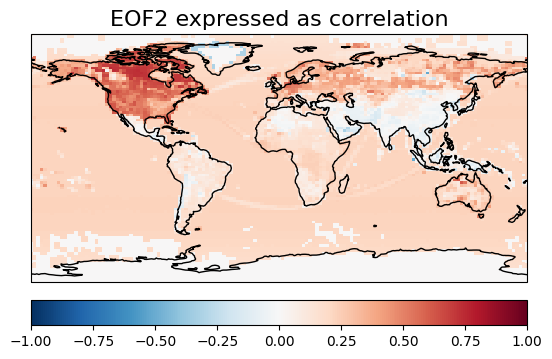

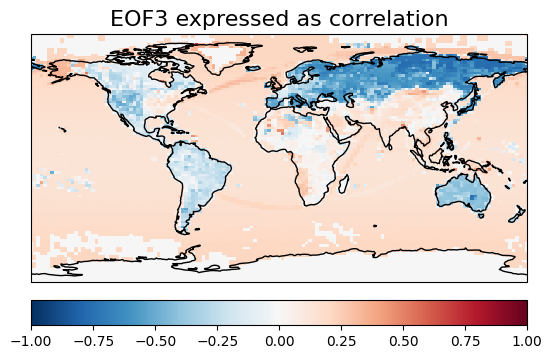

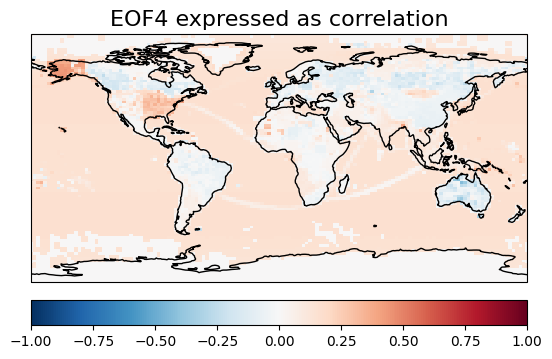

In [7]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
bc_solver = Eof(X['BC'])

# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
bc_eofs = bc_solver.eofsAsCorrelation(neofs=5)
bc_pcs = bc_solver.pcs(npcs=5, pcscaling=1)
#added line to replace NaN values with 0, can be updated with mean values also or some other statistical estimator
bc_eofs_filled = bc_eofs.fillna(0) 

###.....This original plotting code has inconsistencies. So it has been modified 

# for mode, eof  in bc_eofs.groupby('mode'):
#     # Plot the leading EOF expressed as correlation in the Pacific domain.
#     clevs = np.linspace(-1, 1, 11)
#     eof.plot.pcolormesh(subplot_kws={'projection': ccrs.PlateCarree()},
#                         cbar_kwargs={'label': '', 'orientation':'horizontal'}, vmin=-1.)
#     plt.gca().coastlines()
#     plt.gca().set_title(f"EOF{mode} expressed as correlation", fontsize=16)
#     plt.show()


# Assuming bc_eofs_filled is the EOF data with NaNs filled
for mode, eof in bc_eofs_filled.groupby('mode'):
    # Set up the map projection and the coastlines
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Plot the leading EOF expressed as correlation using the reversed 'RdBu' colormap and add colorbar
    im = eof.plot.pcolormesh(ax=ax, cmap='RdBu_r', vmin=-1, vmax=1,
                             add_colorbar=False, transform=ccrs.PlateCarree())
    
    # Add coastlines to the plot
    ax.coastlines()
    
    # Add a colorbar
    cbar = plt.colorbar(im, orientation='horizontal', pad=0.05)
    cbar.set_label('')
    
    # Set the title
    ax.set_title(f"EOF{mode} expressed as correlation", fontsize=16)
    

    plt.show()

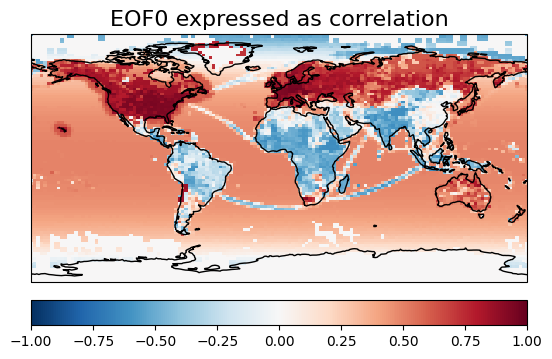

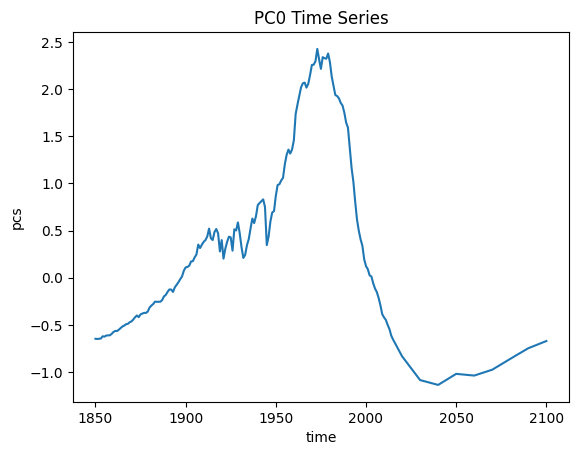

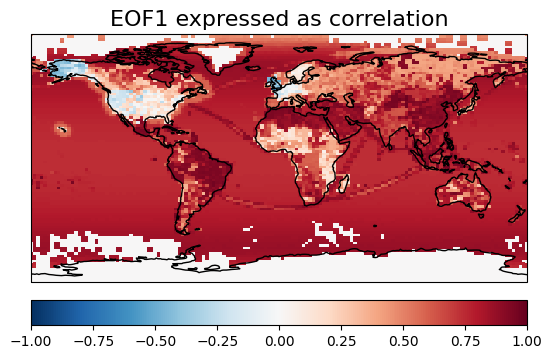

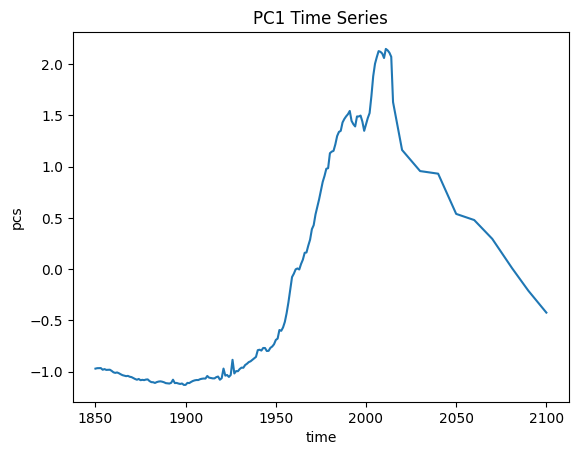

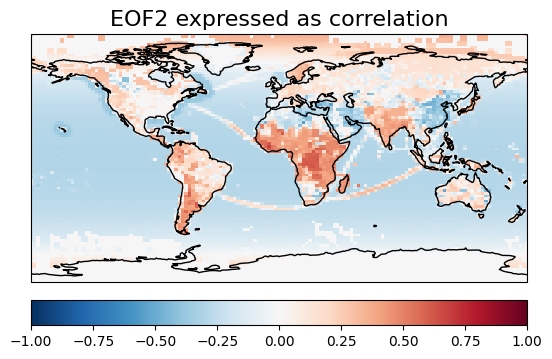

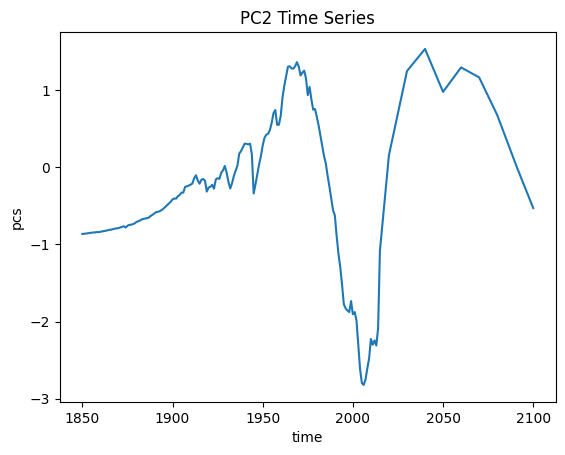

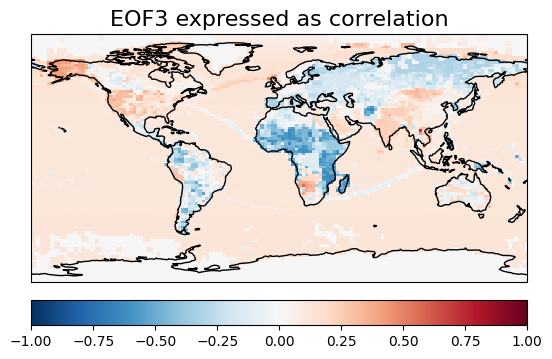

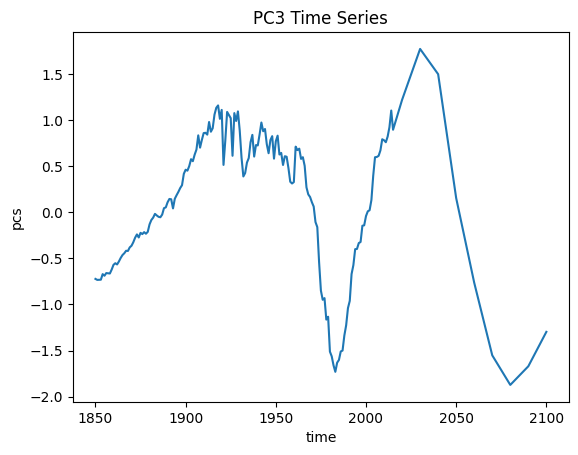

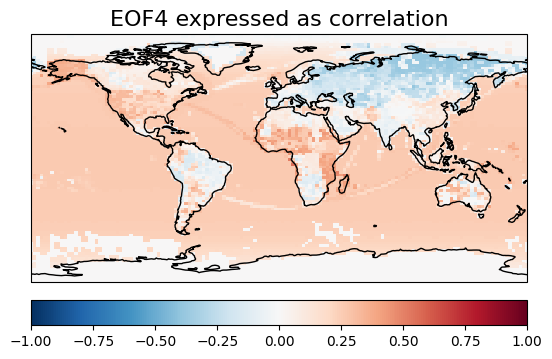

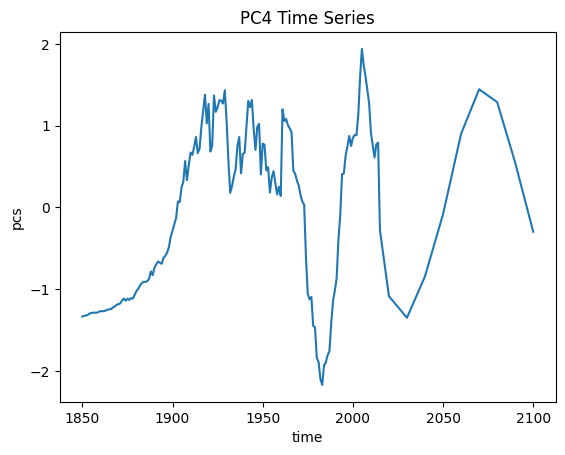

In [8]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
so2_solver = Eof(X['SO2'])

# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
so2_eofs = so2_solver.eofsAsCorrelation(neofs=5)
so2_pcs = so2_solver.pcs(npcs=5, pcscaling=1)

# for (mode, eof), (_, pc) in zip(so2_eofs.groupby('mode'), so2_pcs.groupby('mode')):
#     # Plot the leading EOF expressed as correlation in the Pacific domain.
#     clevs = np.linspace(-1, 1, 11)
#     eof.plot.pcolormesh(subplot_kws={'projection': ccrs.PlateCarree()},
#                         cbar_kwargs={'label': '', 'orientation':'horizontal'}, vmin=-1.)
#     plt.gca().coastlines()
#     plt.gca().set_title(f"EOF{mode} expressed as correlation", fontsize=16)
#     plt.show()
#     pc.plot()
#     plt.show()

#.....Original Plotting code is ommitted for the same reason as the previous  block
# Assuming that so2_eofs is the EOF data for SO2
so2_eofs_filled = so2_eofs.fillna(0)  # Replace NaN values with 0

for (mode, eof), (_, pc) in zip(so2_eofs_filled.groupby('mode'), so2_pcs.groupby('mode')):
    # Set up the map projection and the coastlines
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Plot the leading EOF expressed as correlation using the reversed 'RdBu' colormap and add colorbar
    im = eof.plot.pcolormesh(ax=ax, cmap='RdBu_r', vmin=-1, vmax=1,
                             add_colorbar=False, transform=ccrs.PlateCarree())
    
    # Add coastlines to the plot
    ax.coastlines()
    
    # Add a colorbar
    cbar = plt.colorbar(im, orientation='horizontal', pad=0.05)
    cbar.set_label('')
    
    # Set the title
    ax.set_title(f"EOF{mode} expressed as correlation", fontsize=16)
    
    plt.show()

    # Plot the principal component time series
    pc.plot()
    plt.title(f"PC{mode} Time Series")
    plt.show()

In [9]:
# Convert the Principle Components of the aerosol emissions (calculated above) in to Pandas DataFrames
bc_df = bc_pcs.to_dataframe().unstack('mode')
bc_df.columns = [f"BC_{i}" for i in range(5)]

so2_df = so2_pcs.to_dataframe().unstack('mode')
so2_df.columns = [f"SO2_{i}" for i in range(5)]

In [10]:
# Bring the emissions data back together again and normalise
leading_historical_inputs = pd.DataFrame({
    "CO2": normalize_co2(X["CO2"].data),
    "CH4": normalize_ch4(X["CH4"].data)
}, index=X["CO2"].coords['time'].data)

# Combine with aerosol EOFs
leading_historical_inputs=pd.concat([leading_historical_inputs, bc_df, so2_df], axis=1)

In [11]:
leading_historical_inputs

,CO2,CH4,BC_0,BC_1,BC_2,BC_3,BC_4,SO2_0,SO2_1,SO2_2,SO2_3,SO2_4
1850,0.000078,0.052177,-0.898978,-0.444571,-2.071612,-0.111809,-0.690692,-0.648146,-0.970250,-0.865609,-0.722246,-1.334943
1851,0.000157,0.052903,-0.897957,-0.445609,-2.073209,-0.143129,-0.629810,-0.650408,-0.965991,-0.863111,-0.733084,-1.328654
1852,0.000239,0.053630,-0.902637,-0.437179,-2.040282,-0.128963,-0.619896,-0.647632,-0.965648,-0.859436,-0.732103,-1.322698
1853,0.000325,0.054356,-0.907249,-0.428673,-2.007596,-0.115736,-0.604771,-0.645783,-0.965185,-0.857202,-0.730953,-1.316006
1854,0.000425,0.055082,-0.936984,-0.381277,-1.826662,0.098731,-0.772527,-0.621943,-0.981160,-0.853043,-0.670587,-1.298459
...,...,...,...,...,...,...,...,...,...,...,...,...
2096,3.687235,0.796235,-0.244580,-1.296961,-1.457472,-1.154899,-0.342804,-0.702640,-0.338410,-0.296534,-1.446580,0.039953
2097,3.740900,0.791031,-0.282719,-1.270916,-1.570341,-1.187619,-0.380739,-0.695011,-0.359812,-0.354873,-1.409224,-0.044627
2098,3.794429,0.785826,-0.320858,-1.244872,-1.683211,-1.220338,-0.418675,-0.687382,-0.381214,-0.413213,-1.371868,-0.129208
2099,3.847823,0.780622,-0.358998,-1.218827,-1.796081,-1.253058,-0.456610,-0.679753,-0.402616,-0.471553,-1.334512,-0.213789


# Build baseline model

In [12]:
from esem import gp_model
from esem.data_processors import Whiten, Normalise

# Just a *very* simple GP with default kernel assuming all years are independant

tas_gp = gp_model(leading_historical_inputs, Y["tas"])
tas_gp.train()

2024-01-28 22:12:56.165206: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-28 22:12:56.165302: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-01-28 22:12:56.165378: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-01-28 22:12:56.167781: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2024-01-28 22:12:56.167862: W tensorflow/stream_executor/platform/default/dso_loader

In [13]:
pr_gp = gp_model(leading_historical_inputs, Y["pr"])
pr_gp.train()

In [14]:
dtr_gp = gp_model(leading_historical_inputs, Y["diurnal_temperature_range"])
dtr_gp.train()

In [15]:
pr90_gp = gp_model(leading_historical_inputs, Y["pr90"])
pr90_gp.train()

## Gather the test data

In [16]:
# Will be hidden from contestants
tas_truth = test_Y["tas"].mean('member')
pr_truth = test_Y["pr"].mean('member') * 86400
pr90_truth = test_Y["pr90"].mean('member') * 86400
dtr_truth = test_Y["diurnal_temperature_range"].mean('member')


In [17]:
test_inputs = pd.DataFrame({
    "CO2": normalize_co2(test_X["CO2"].data),
    "CH4": normalize_ch4(test_X["CH4"].data)
}, index=test_X["CO2"].coords['time'].data)

# Combine with aerosol EOFs
test_inputs=pd.concat([test_inputs, 
                       bc_solver.projectField(test_X["BC"], neofs=5, eofscaling=1).to_dataframe().unstack('mode').rename(columns={i:f"BC_{i}" for i in range(5)}),
                       so2_solver.projectField(test_X["SO2"], neofs=5, eofscaling=1).to_dataframe().unstack('mode').rename(columns={i:f"_{i}" for i in range(5)}),
                       ], axis=1)

# Evaluate predictions

In [18]:
m_tas, _ = tas_gp.predict(test_inputs)
m_pr, _ = pr_gp.predict(test_inputs)
m_pr90, _ = pr90_gp.predict(test_inputs)
m_dtr, _ = dtr_gp.predict(test_inputs)

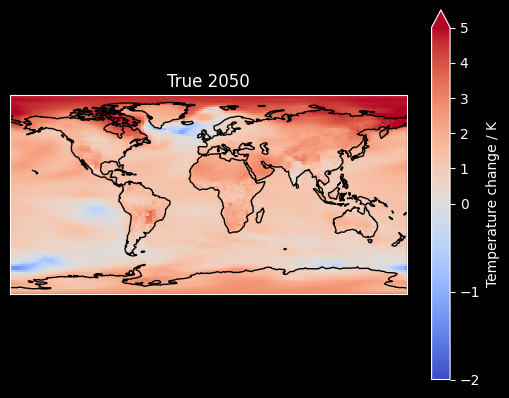

In [19]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)

with plt.style.context("dark_background"):
    ax = plt.axes(projection=ccrs.PlateCarree())
    tas_truth.sel(time=2050).plot(cmap="coolwarm", norm=divnorm,
                                  cbar_kwargs={"label":"Temperature change / K"})
    ax.set_title("True 2050")
    ax.coastlines()

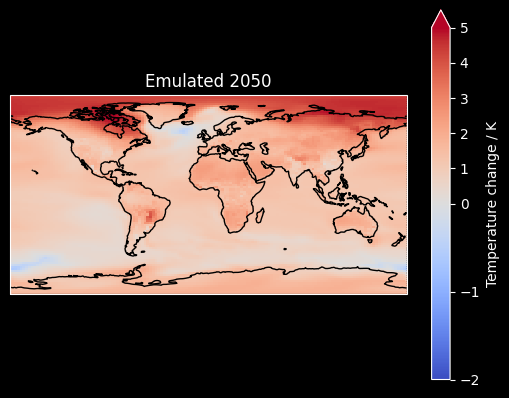

In [20]:
with plt.style.context("dark_background"):
    ax = plt.axes(projection=ccrs.PlateCarree())
    m_tas.sel(sample=35).plot(cmap="coolwarm", norm=divnorm,
                             cbar_kwargs={"label":"Temperature change / K"})
    ax.set_title("Emulated 2050")
    ax.coastlines()

### These are the metrics to be scored on

In [21]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data

print(f"RMSE at 2015: {get_rmse(tas_truth[0], m_tas[0])}")
print(f"RMSE at 2050: {get_rmse(tas_truth[35], m_tas[35])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[85], m_tas[85])}")

RMSE at 2015: 0.36470422452039786
RMSE at 2050: 0.3211024531543686
RMSE at 2100: 0.40406339937603164


In [22]:
print(f"RMSE at 2015: {get_rmse(dtr_truth[0], m_dtr[0])}")
print(f"RMSE at 2050: {get_rmse(dtr_truth[35], m_dtr[35])}")
print(f"RMSE at 2100: {get_rmse(dtr_truth[85], m_dtr[85])}")

RMSE at 2015: 0.15896205664984014
RMSE at 2050: 0.14319081857399318
RMSE at 2100: 0.15348355667233257


In [23]:
print(f"RMSE at 2015: {get_rmse(pr_truth[0], m_pr[0])}")
print(f"RMSE at 2050: {get_rmse(pr_truth[35], m_pr[35])}")
print(f"RMSE at 2100: {get_rmse(pr_truth[85], m_pr[85])}")

RMSE at 2015: 0.39136915955825063
RMSE at 2050: 0.41957692282152215
RMSE at 2100: 0.6270705241376581


In [24]:
print(f"RMSE at 2015: {get_rmse(pr90_truth[0], m_pr90[0])}")
print(f"RMSE at 2050: {get_rmse(pr90_truth[35], m_pr90[35])}")
print(f"RMSE at 2100: {get_rmse(pr90_truth[85], m_pr90[85])}")

RMSE at 2015: 1.1972013045232628
RMSE at 2050: 1.2911386018605429
RMSE at 2100: 1.8188062656995827


In [25]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon', 'sample', 'time'])).data

print(f"RMSE: {get_rmse(tas_truth, m_tas)}")
print(f"RMSE: {get_rmse(dtr_truth, m_dtr)}")
print(f"RMSE: {get_rmse(pr_truth, m_pr)}")
print(f"RMSE: {get_rmse(pr90_truth, m_pr90)}")



RMSE: 0.8036311643722416
RMSE: 0.18055097316862218
RMSE: 0.6111164984694795
RMSE: 1.751974708262459
